In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-12-30 14:24:48--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2022-12-30 14:24:49 (88.8 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
dataset.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [5]:
df_=pd.get_dummies(dataset, columns=['sex', 'smoker','region'], drop_first=True)
df_.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0,1,0,0,1
1,18,33.8,1,1725.55,1,0,0,1,0
2,28,33.0,3,4449.46,1,0,0,1,0
3,33,22.7,0,21984.47,1,0,1,0,0
4,32,28.9,0,3866.86,1,0,1,0,0


In [6]:
smoker_yes=df_['smoker_yes'].to_numpy()
age=df_['age'].to_numpy()
rnw=df_['region_northwest'].to_numpy()
rse=df_['region_southeast'].to_numpy()
rsw=df_['region_southwest'].to_numpy()
sex=df_['sex_male'].to_numpy()

In [7]:
df_['sxa'] = pd.Series(smoker_yes*age)
df_['rnwxa']=pd.Series(rnw*age)
df_['rsexa']=pd.Series(rse*age)
df_['rswxa']=pd.Series(rsw*age)
df_['sexxa']=pd.Series(sex*age)

In [8]:
df_.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,sxa,rnwxa,rsexa,rswxa,sexxa
0,19,27.9,0,16884.92,0,1,0,0,1,19,0,0,19,0
1,18,33.8,1,1725.55,1,0,0,1,0,0,0,18,0,18
2,28,33.0,3,4449.46,1,0,0,1,0,0,0,28,0,28
3,33,22.7,0,21984.47,1,0,1,0,0,0,33,0,0,33
4,32,28.9,0,3866.86,1,0,1,0,0,0,32,0,0,32


In [9]:
tot_train=int(df_.count()[0]*.8)
train_dataset = df_[:tot_train]
test_dataset = df_[tot_train:]

In [10]:
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))

In [12]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=20),
    loss='mean_absolute_error',metrics=['mae','mse'])

In [13]:
%%time
history = model.fit(
    train_dataset,
    train_labels,
    epochs=200,
    verbose=0,
    validation_split = 0.2)

CPU times: user 24.3 s, sys: 2.05 s, total: 26.4 s
Wall time: 28.4 s


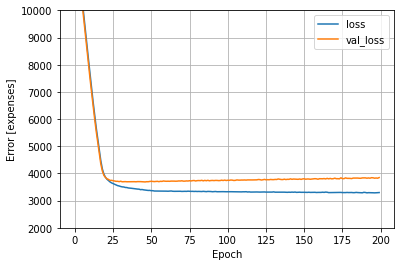

In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([2000, 10000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [expenses]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

9/9 - 0s - loss: 3478.8210 - mae: 3478.8210 - mse: 45150376.0000 - 33ms/epoch - 4ms/step
Testing set Mean Abs Error: 3478.82 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


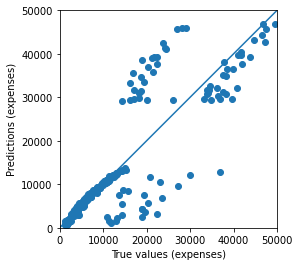

In [19]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
